## Make Training Data for Biomass Estimation from NEON TOS Vegetation Structure Data

This notebook walks through generating a biomass training dataset (namely obtaining tree stem diameter, species, and location) from NEON Terrestrial Observation System (TOS) Vegetation Structure data (DP1.10098.001). The stem diameters can then be linked to trees delineated from the Canopy Height Model, and a machine learning model can be applied to estimate biomass over the larger area.

Resources

Refer to the <a href="https://data.neonscience.org/api/v0/documents/NEON_vegStructure_userGuide_vE?inline=true" target=_blank> vegetation structure user guide</a> for more details on this data product, and to better understand the data quality flags, the sampling design, and other important information that will determine how you carry out your analysis.

**Disclaimer**: this notebook is intended to provide an example of how to procure training data and conduct some exploratory analysis, it is not the recommended method. A number of simplifications / assumptions are made along the way, including:

1) using woody vegetation data from all dates, to include the most data possible
2) selecting only single-bole trees (removed all multi-bole trees and shrubs, which account for a large # of the vegetation in the dataset; multi-bole trees have a different allometric relationship)
3) simplified outlier detection to remove trees that don't align with the CHM
4) biomass allometric calculations are obtained from Jenkins et al 2004, there are newer publications available (eg. Chognacky 2013)

In [4]:
import os, glob, subprocess, requests
from osgeo import gdal
import rasterio as rio
from rasterio.merge import merge
from rasterio.plot import show
# import georasters as gr
import numpy as np
import pandas as pd
from math import floor, ceil
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import seaborn as sns
import neonutilities as nu

## Vegetation Structure Data (DP1.10098.001)

In this section we’ll download the vegetation structure data, find the locations of the mapped trees, and join to the species and DBH (diameter at breast height) data.

Download the vegetation structure data using the `load_by_product` function in the `neonutilities` package (imported as `nu`). Inputs to the function can be shown by typing `help(load_by_product)`.
  
Refer to th e<a href=https://www.neonscience.org/sites/default/files/cheat-sheet-neonUtilities.pdf target=_blank> R neonutilities cheat sheet</a>  or the neonUtilities package for more details and the complete index of possible function inputs. The cheat sheet is focused on the R package, but nearly all the inputs are the same

Note that in this example, we will pull in all the woody vegetation data (collected over all years), but if you are trying to model heights measured in a single year, you can select just that year by specifying the `startdate` and `enddate`, or later filtering out the vegetation data by the eventID. See the <a href=https://github.com/NEONScience/NEON-Data-Skills/blob/main/tutorials/R/AOP/Lidar/lidar-topography/veg_structure_and_chm/veg_structure_and_chm-content.html target=_blank> vegetation structure and chm lesson</a> for more details on how to filter by eventID. .

In [5]:
veg_dict = nu.load_by_product(dpid="DP1.10098.001", 
                              site="SJER", 
                              package="basic", 
                              release="RELEASE-2025",
                              check_size=False)

Finding available files
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:13<00:00,  1.08it/s]
Stacking data files
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 31.55it/s]


Get a list of the points

In [6]:
veg_map_all = veg_dict["vst_mappingandtagging"]
veg_map = veg_map_all.loc[veg_map_all["pointID"] != ""]
veg_map = veg_map.reindex()
veg_map["points"] = veg_map["namedLocation"] + "." + veg_map["pointID"]
veg_points = list(set(list(veg_map["points"])))

In [21]:
veg_dict.keys()

dict_keys(['categoricalCodes_10098', 'citation_10098_RELEASE-2025', 'issueLog_10098', 'readme_10098', 'validation_10098', 'variables_10098', 'vst_apparentindividual', 'vst_mappingandtagging', 'vst_perplotperyear', 'vst_shrubgroup'])

Look at the unique `eventID`s. 

In [7]:
veg_map_all.eventID.unique()

array(['vst_SJER_2015', 'vst_SJER_2016', 'vst_SJER_2019', 'vst_SJER_2020',
       'vst_SJER_2021', 'vst_SJER_2022', 'vst_SJER_2023', 'vst_SJER_2024'],
      dtype=object)

Get the number of records for each eventID:

In [12]:
# Group by 'eventID' and get the count
eventID_counts = veg_map_all[['individualID','eventID']].groupby(['eventID']).count()
print("\nCounts of each eventID:\n", eventID_counts)


Counts of each eventID:
                individualID
eventID                    
vst_SJER_2015           196
vst_SJER_2016           446
vst_SJER_2019            50
vst_SJER_2020             4
vst_SJER_2021            30
vst_SJER_2022            23
vst_SJER_2023             4
vst_SJER_2024            11


It looks like most of the trees were mapped in 2016. You could look at that year, and compare to AOP data (see below to determine which dates of AOP data are available), or if you are not too worried about matching measurements to remote sensing data collected in the same year, you could use all years. We'll do that in this example, but you have some options here.

Loop through all of the points in veg_points to determine the easting and norhting from the locations API

In [13]:
easting = []
northing = []
coord_uncertainty = []
elev_uncertainty = []
for i in veg_points:
    vres = requests.get("https://data.neonscience.org/api/v0/locations/"+i)
    vres_json = vres.json()
    easting.append(vres_json["data"]["locationUtmEasting"])
    northing.append(vres_json["data"]["locationUtmNorthing"])
    props = pd.DataFrame.from_dict(vres_json["data"]["locationProperties"])
    cu = props.loc[props["locationPropertyName"]=="Value for Coordinate uncertainty"]["locationPropertyValue"]
    coord_uncertainty.append(cu[cu.index[0]])
    eu = props.loc[props["locationPropertyName"]=="Value for Elevation uncertainty"]["locationPropertyValue"]
    elev_uncertainty.append(eu[eu.index[0]])

pt_dict = dict(points=veg_points, 
               easting=easting,
               northing=northing,
               coordinateUncertainty=coord_uncertainty,
               elevationUncertainty=elev_uncertainty)

pt_df = pd.DataFrame.from_dict(pt_dict)
pt_df.set_index("points", inplace=True)

veg_map = veg_map.join(pt_df, 
                     on="points", 
                     how="inner")

Next, use the stemDistance and stemAzimuth data to calculate the precise locations of individuals, relative to the reference locations.

- $Easting = easting.pointID + stemDistance*sin(\theta)$
- $Northing = northing.pointID + stemDistance*cos(\theta)$
- $\theta = stemAzimuth*\pi/180$

Also adjust the coordinate and elevation uncertainties.

In [17]:
veg_map["adjEasting"] = (veg_map["easting"]
                        + veg_map["stemDistance"]
                        * np.sin(veg_map["stemAzimuth"]
                                   * np.pi / 180))

veg_map["adjNorthing"] = (veg_map["northing"]
                        + veg_map["stemDistance"]
                        * np.cos(veg_map["stemAzimuth"]
                                   * np.pi / 180))

veg_map["adjCoordinateUncertainty"] = veg_map["coordinateUncertainty"] + 0.6

veg_map["adjElevationUncertainty"] = veg_map["elevationUncertainty"] + 1

Look at the columns to see all the information contained in this dataset.

In [18]:
veg_map.columns

Index(['uid', 'namedLocation', 'date', 'eventID', 'domainID', 'siteID',
       'plotID', 'pointID', 'stemDistance', 'stemAzimuth', 'recordType',
       'individualID', 'supportingStemIndividualID', 'previouslyTaggedAs',
       'otherTagID', 'otherTagOrg', 'samplingProtocolVersion',
       'identificationHistoryID', 'taxonID', 'scientificName', 'genus',
       'family', 'taxonRank', 'identificationReferences', 'morphospeciesID',
       'morphospeciesIDRemarks', 'identificationQualifier', 'remarks',
       'measuredBy', 'recordedBy', 'dataQF', 'publicationDate', 'release',
       'points', 'easting', 'northing', 'coordinateUncertainty',
       'elevationUncertainty', 'adjEasting', 'adjNorthing',
       'adjCoordinateUncertainty', 'adjElevationUncertainty'],
      dtype='object')

### Combine location with tree traits

Now we have the mapped locations of individuals in the vst_mappingandtagging table, and the annual measurements of tree dimensions such as height and diameter in the vst_apparentindividual table. To bring these measurements together, join the two tables. Refer to the Quick Start Guide for Vegetation structure for more information about the data tables and the joining instructions.

In [22]:
veg_dict["vst_apparentindividual"].set_index("individualID", inplace=True)
veg = veg_map.join(veg_dict["vst_apparentindividual"],
                   on="individualID",
                   how="inner",
                   lsuffix="_MAT",
                   rsuffix="_AI")

In [23]:
# show all the columns in the joined veg dataset
veg.columns

Index(['uid_MAT', 'namedLocation_MAT', 'date_MAT', 'eventID_MAT',
       'domainID_MAT', 'siteID_MAT', 'plotID_MAT', 'pointID', 'stemDistance',
       'stemAzimuth', 'recordType', 'individualID',
       'supportingStemIndividualID', 'previouslyTaggedAs', 'otherTagID',
       'otherTagOrg', 'samplingProtocolVersion', 'identificationHistoryID',
       'taxonID', 'scientificName', 'genus', 'family', 'taxonRank',
       'identificationReferences', 'morphospeciesID', 'morphospeciesIDRemarks',
       'identificationQualifier', 'remarks_MAT', 'measuredBy_MAT',
       'recordedBy_MAT', 'dataQF_MAT', 'publicationDate_MAT', 'release_MAT',
       'points', 'easting', 'northing', 'coordinateUncertainty',
       'elevationUncertainty', 'adjEasting', 'adjNorthing',
       'adjCoordinateUncertainty', 'adjElevationUncertainty', 'uid_AI',
       'namedLocation_AI', 'date_AI', 'eventID_AI', 'domainID_AI', 'siteID_AI',
       'plotID_AI', 'subplotID', 'tempStemID', 'tagStatus', 'growthForm',
       'plan

In [26]:
# pull out a subset of the columns that may be relevant
veg[['date_AI','individualID','scientificName','taxonID','family','growthForm','plantStatus','plotID_AI','pointID','stemDiameter','maxBaseCrownDiameter','adjEasting','adjNorthing']]#.head(5)

,date_AI,individualID,scientificName,taxonID,family,growthForm,plantStatus,plotID_AI,pointID,stemDiameter,maxBaseCrownDiameter,adjEasting,adjNorthing
0,2015-04-14,NEON.PLA.D17.SJER.00204,Ceanothus cuneatus (Hook.) Nutt.,CECU,Rhamnaceae,small shrub,Live,SJER_054,21,NaN,19.0,257186.709289,4.111270e+06
0,2015-04-14,NEON.PLA.D17.SJER.00204,Ceanothus cuneatus (Hook.) Nutt.,CECU,Rhamnaceae,small shrub,Live,SJER_054,21,NaN,19.0,257186.709289,4.111270e+06
0,2016-11-15,NEON.PLA.D17.SJER.00204,Ceanothus cuneatus (Hook.) Nutt.,CECU,Rhamnaceae,small shrub,Live,SJER_054,21,NaN,2.2,257186.709289,4.111270e+06
0,2016-11-15,NEON.PLA.D17.SJER.00204,Ceanothus cuneatus (Hook.) Nutt.,CECU,Rhamnaceae,small shrub,Live,SJER_054,21,NaN,2.2,257186.709289,4.111270e+06
0,2016-11-15,NEON.PLA.D17.SJER.00204,Ceanothus cuneatus (Hook.) Nutt.,CECU,Rhamnaceae,small shrub,Live,SJER_054,21,NaN,2.2,257186.709289,4.111270e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,2023-12-05,NEON.PLA.D17.SJER.00246,Quercus douglasii Hook. & Arn.,QUDO,Fagaceae,single bole tree,Live,SJER_050,21,59.7,NaN,256577.314020,4.110832e+06
739,2022-11-16,NEON.PLA.D17.SJER.04780,Quercus wislizeni A. DC.,QUWI2,Fagaceae,single bole tree,Live,SJER_003,49,11.5,NaN,257405.320045,4.111310e+06
755,2019-11-04,NEON.PLA.D17.SJER.04915,Pinus sabiniana Douglas ex Douglas,PISA2,Pinaceae,single bole tree,Live,SJER_016,41,32.8,NaN,258545.641668,4.106901e+06
757,2016-11-29,NEON.PLA.D17.SJER.04991,Ceanothus leucodermis Greene,CELE2,Rhamnaceae,single shrub,Live,SJER_015,41,1.6,NaN,258182.524120,4.107431e+06


We can see that stemDiameter is not collected for all of the trees. Let's save a subset of the coluns 

In [28]:
veg_short = veg[['date_AI','individualID','scientificName','taxonID','family','growthForm','plantStatus','plotID_AI','pointID','stemDiameter','maxBaseCrownDiameter','adjEasting','adjNorthing','dataQF_AI']]
veg_short.to_csv('/data/chloris/NEON/veg_all.csv',index=False)

The next cells contain some exploratory analysis to get a better sense of the dataset contents

In [32]:
veg_short.stemDiameter.describe()

count    826.000000
mean      18.130508
std       18.102617
min        1.000000
25%        3.325000
50%       10.800000
75%       29.175000
max       79.500000
Name: stemDiameter, dtype: float64

In [33]:
print('unique growth forms:',veg['growthForm'].unique())
print('unique taxonIds:',list(veg['taxonID'].unique()))
print('unique families:',list(veg['family'].unique()))

unique growth forms: ['small shrub' 'single bole tree' 'multi-bole tree' '' 'single shrub'
 'small tree' 'sapling']
unique taxonIds: ['CECU', 'QUDO', 'QUWI2', 'PISA2', 'ARVIM', 'CELE2', 'RHIL', 'AECA', 'LUAL4', 'FRCAC7']
unique families: ['Rhamnaceae', 'Fagaceae', 'Pinaceae', 'Ericaceae', 'Hippocastanaceae', 'Fabaceae']


In [35]:
# show the total # of each growth form - for this example we're going to focus only on trees (single bole and saplings), for simplicity
# Group by 'plotID_AI' and count the occurrences of 'growthForm'
grouped_by_growth_form = veg.groupby(['growthForm']).count()

# Sort the resulting DataFrame in descending order
sorted_growth_form = grouped_by_growth_form.sort_values(by='plotID_AI', ascending=False)
sorted_growth_form['plotID_AI']

growthForm
single shrub        423
single bole tree    235
small shrub         194
multi-bole tree     177
                     23
small tree           12
sapling               9
Name: plotID_AI, dtype: int64

In [36]:
# count the total number of trees (including saplings) - this excludes shrubs
trees = veg[veg['growthForm'].str.contains('tree|sapling', regex=True)]
len(trees)

433

In [37]:
# show the total number of trees that have a 'stemDiameter' measurement
trees_dbh = trees[trees['stemDiameter'].notna()]
len(trees_dbh)

420

In [38]:
# drop_duplicates to get the total # of unique trees; there may be some repeat measurements
trees_unique = trees_dbh[['date_AI','individualID','scientificName','taxonID','family','growthForm','plotID_AI','pointID','stemDiameter','maxBaseCrownDiameter','adjEasting','adjNorthing']].drop_duplicates()
len(trees_unique)

332

In [40]:
grouped_by_taxon = trees_unique.groupby(['taxonID']).count()

# Sort the resulting DataFrame by the count of 'basalStemDiameter' in descending order
sorted_taxon = grouped_by_taxon.sort_values(by='plotID_AI', ascending=False)
sorted_taxon['plotID_AI']

taxonID
QUDO     134
QUWI2    120
PISA2     69
AECA       4
ARVIM      2
CELE2      2
RHIL       1
Name: plotID_AI, dtype: int64

Refer to https://plants.usda.gov/ for more details on the different taxonIDs. Most of the trees sampled are Oaks, which is the dominant tree species in San Juaquin. More info on these species are provided later one.

In [41]:
# Group by 'plotID_AI' and count the occurrences of 'stemDiameter'
grouped_counts = trees_unique[['stemDiameter', 'plotID_AI']].groupby(['plotID_AI']).count()

# Sort the resulting DataFrame by the count of 'stemDiameter' in descending order
sorted_counts = grouped_counts.sort_values(by='stemDiameter', ascending=False)
sorted_counts.head(10)

,stemDiameter
plotID_AI,
SJER_050,40
SJER_057,28
SJER_047,27
SJER_046,27
SJER_049,22
SJER_053,21
SJER_063,19
SJER_045,16
SJER_008,15


For simplicity, just look at single bole trees that have a stemDiameter value. The first cell shows how many there are.

In [42]:
trees_single_bole = trees[(trees['growthForm']=='single bole tree') & (trees['stemDiameter'].notna())]
len(trees_single_bole) # show the total # of single bole tree measurements

235

Some of these are duplicates. Look at the number of unique `individualIDs` as follows:

In [43]:
len(trees_single_bole['individualID'].unique())

76

We have 76 single bole trees to work with at this site. The cell below shows how to keep only the latest measurement for each of these trees.

In [44]:
# Convert 'date_AI' to datetime if it's not already
trees_single_bole.loc[:, 'date_AI'] = pd.to_datetime(trees_single_bole['date_AI'])

# Sort the DataFrame by 'individualID' and 'date_AI' in descending order
trees_sb_sorted = trees_single_bole.sort_values(by=['individualID', 'date_AI'], ascending=[True, False])

# Drop duplicates, keeping the first occurrence (which is the latest, or most recent, due to sorting)
trees_sb_latest = trees_sb_sorted.drop_duplicates(subset='individualID', keep='first').copy()

# Display the DataFrame with only the latest entries for each individualID
print(len(trees_sb_latest))

76


Let's look at the single bole dataset, including only the latest measurements:

In [45]:
trees_sb_latest[['date_AI','individualID','scientificName','taxonID','family','growthForm','plantStatus','stemDiameter','adjEasting','adjNorthing']]

,date_AI,individualID,scientificName,taxonID,family,growthForm,plantStatus,stemDiameter,adjEasting,adjNorthing
14,2016-11-15 00:00:00,NEON.PLA.D17.SJER.00001,Quercus douglasii Hook. & Arn.,QUDO,Fagaceae,single bole tree,Live,28.5,257179.618541,4.111285e+06
130,2016-11-11 00:00:00,NEON.PLA.D17.SJER.00014,Quercus douglasii Hook. & Arn.,QUDO,Fagaceae,single bole tree,Live,32.3,257600.854612,4.111210e+06
98,2016-11-11 00:00:00,NEON.PLA.D17.SJER.00017,Quercus douglasii Hook. & Arn.,QUDO,Fagaceae,single bole tree,Live,42.6,257599.870838,4.111193e+06
42,2023-11-29 00:00:00,NEON.PLA.D17.SJER.00037,Quercus wislizeni A. DC.,QUWI2,Fagaceae,single bole tree,Standing dead,19.4,257517.019886,4.111014e+06
221,2016-11-09 00:00:00,NEON.PLA.D17.SJER.00040,Quercus douglasii Hook. & Arn.,QUDO,Fagaceae,single bole tree,Live,40.3,257599.099435,4.110864e+06
...,...,...,...,...,...,...,...,...,...,...
497,2016-11-29 00:00:00,NEON.PLA.D17.SJER.04916,Aesculus californica (Spach) Nutt.,AECA,Hippocastanaceae,single bole tree,Live,29.6,258495.945761,4.107218e+06
489,2016-11-29 00:00:00,NEON.PLA.D17.SJER.04934,Quercus douglasii Hook. & Arn.,QUDO,Fagaceae,single bole tree,Live,57.8,258186.945792,4.107420e+06
564,2019-12-04 00:00:00,NEON.PLA.D17.SJER.04935,Pinus sabiniana Douglas ex Douglas,PISA2,Pinaceae,single bole tree,Live,36.9,255750.442110,4.112691e+06
559,2022-11-16 00:00:00,NEON.PLA.D17.SJER.04939,Pinus sabiniana Douglas ex Douglas,PISA2,Pinaceae,single bole tree,Live,35.7,257409.631783,4.111303e+06


In [46]:
trees_sb_latest.to_csv('/data/chloris/NEON/trees_single_bole_latest.csv',index=False)

## Canopy Height Model Data (CHM - DP3.30015.001)

Next we can pull down the corresponding CHM data. The latest version of neonUtilities (not yet available on PyPI, but available on GitHub) has a function that shows what dates are available, using `list_available_dates`. 

In [47]:
nu.list_available_dates(dpid='DP3.30015.001',site='SJER')

PROVISIONAL Available Dates: 2024-04
RELEASE-2025 Available Dates: 2013-06, 2017-03, 2018-03, 2019-03, 2021-03, 2023-04


The most recent data is from 2024, so we can use that. This is still available provisionally  (eg. not as part of a NEON data release), because everything generated in 2024 is provisional in 2025 (there is a year lag period). The data should be good as long as there are no reported issues in the Issue Logs (see the Data Portal). Next we can see the extent of the data. You don't need to run this step, but it can be helpful for context.

sjer_exts = nu.get_aop_tile_extents('DP3.30015.001','SJER','2024')

Use the Eastings and Northings determined from the vegetation data to download only the tiles that overlay with the veg data points. Use `by_tile_aop` to do this:

In [48]:
sjer_exts = nu.get_aop_tile_extents('DP3.30015.001','SJER','2024')

Easting Bounds: (251000, 262000)
Northing Bounds: (4103000, 4114000)


In [49]:
sjer_exts

[(251000, 4103000),
 (251000, 4104000),
 (251000, 4105000),
 (251000, 4106000),
 (251000, 4107000),
 (251000, 4108000),
 (251000, 4109000),
 (251000, 4110000),
 (251000, 4111000),
 (251000, 4112000),
 (251000, 4113000),
 (251000, 4114000),
 (252000, 4103000),
 (252000, 4104000),
 (252000, 4105000),
 (252000, 4106000),
 (252000, 4107000),
 (252000, 4108000),
 (252000, 4109000),
 (252000, 4110000),
 (252000, 4111000),
 (252000, 4112000),
 (252000, 4113000),
 (252000, 4114000),
 (253000, 4103000),
 (253000, 4104000),
 (253000, 4105000),
 (253000, 4106000),
 (253000, 4107000),
 (253000, 4108000),
 (253000, 4109000),
 (253000, 4110000),
 (253000, 4111000),
 (253000, 4112000),
 (253000, 4113000),
 (253000, 4114000),
 (254000, 4103000),
 (254000, 4104000),
 (254000, 4105000),
 (254000, 4106000),
 (254000, 4107000),
 (254000, 4108000),
 (254000, 4109000),
 (254000, 4110000),
 (254000, 4111000),
 (254000, 4112000),
 (254000, 4113000),
 (254000, 4114000),
 (255000, 4103000),
 (255000, 4104000),


In [50]:
nu.by_tile_aop(dpid="DP3.30015.001", site="SJER", year="2024", 
          easting=list(trees_sb_latest.adjEasting), 
          northing=list(trees_sb_latest.adjNorthing),
          include_provisional=True,
          savepath=os.getcwd())

Provisional NEON data are included. To exclude provisional data, use input parameter include_provisional=False.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  1.84it/s]


Let's see what files were downloaded:

In [51]:
chm_files = []
for root, dirs, files in os.walk("DP3.30015.001"):
    for file in files:
        if file.endswith(".tif"):
            print(file)
            chm_files.append(os.path.join(root,file))

NEON_D17_SJER_DP3_256000_4107000_CHM.tif
NEON_D17_SJER_DP3_257000_4109000_CHM.tif
NEON_D17_SJER_DP3_257000_4110000_CHM.tif
NEON_D17_SJER_DP3_256000_4111000_CHM.tif
NEON_D17_SJER_DP3_256000_4109000_CHM.tif
NEON_D17_SJER_DP3_255000_4112000_CHM.tif
NEON_D17_SJER_DP3_258000_4106000_CHM.tif
NEON_D17_SJER_DP3_257000_4111000_CHM.tif
NEON_D17_SJER_DP3_258000_4107000_CHM.tif
NEON_D17_SJER_DP3_256000_4110000_CHM.tif


In [52]:
# Open the files using rasterio
chm_files_to_mosaic = []
for chm_file in chm_files:
    chm = rio.open(chm_file)
    chm_files_to_mosaic.append(chm_file)

from rasterio.merge import merge
# Merge the rasters, saving the transform info
chm_mosaic, chm_transform = merge(chm_files_to_mosaic)

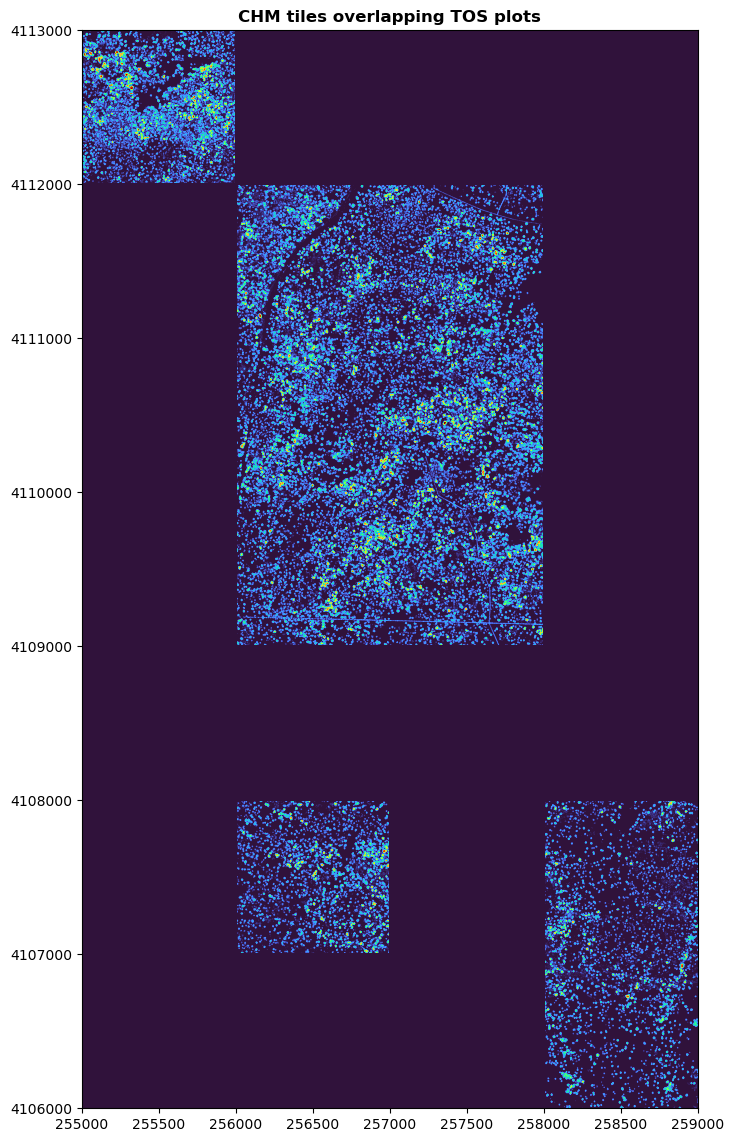

In [55]:
# Plot the merged CHM
fig, ax = plt.subplots(figsize=(8, 14))
show(chm_mosaic, ax=ax, cmap='turbo', vmin=0, vmax=30, transform=chm_transform, title='CHM tiles overlapping TOS plots');
ax.ticklabel_format(style='plain')

To simplify, you can pare down the data again to only look at the central rectangular region. Those are the following 6 tiles:

In [61]:
chm_files_subset = [
 '/home/skwirl/DP3.30015.001/neon-aop-provisional-products/2024/FullSite/D17/2024_SJER_7/L3/DiscreteLidar/CanopyHeightModelGtif/NEON_D17_SJER_DP3_256000_4109000_CHM.tif',
 'DP3.30015.001/neon-aop-provisional-products/2024/FullSite/D17/2024_SJER_7/L3/DiscreteLidar/CanopyHeightModelGtif/NEON_D17_SJER_DP3_256000_4110000_CHM.tif',
 'DP3.30015.001/neon-aop-provisional-products/2024/FullSite/D17/2024_SJER_7/L3/DiscreteLidar/CanopyHeightModelGtif/NEON_D17_SJER_DP3_256000_4111000_CHM.tif',
 'DP3.30015.001/neon-aop-provisional-products/2024/FullSite/D17/2024_SJER_7/L3/DiscreteLidar/CanopyHeightModelGtif/NEON_D17_SJER_DP3_257000_4109000_CHM.tif',
 'DP3.30015.001/neon-aop-provisional-products/2024/FullSite/D17/2024_SJER_7/L3/DiscreteLidar/CanopyHeightModelGtif/NEON_D17_SJER_DP3_257000_4110000_CHM.tif',
 'DP3.30015.001/neon-aop-provisional-products/2024/FullSite/D17/2024_SJER_7/L3/DiscreteLidar/CanopyHeightModelGtif/NEON_D17_SJER_DP3_257000_4111000_CHM.tif']

In [58]:
os.getcwd()

'/home/skwirl'

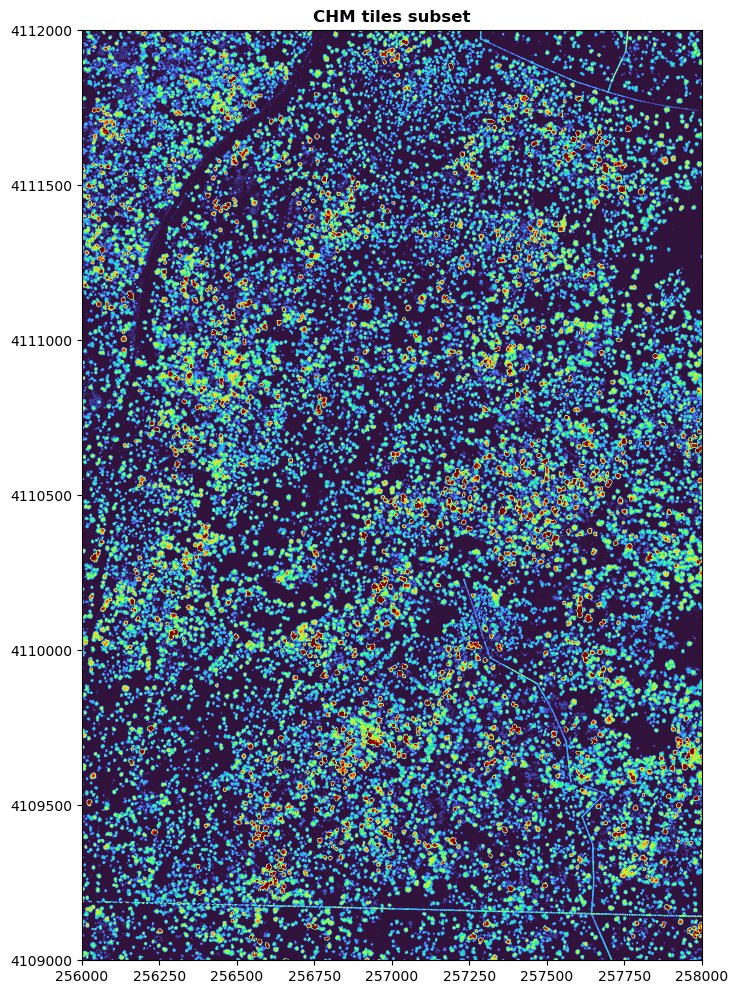

In [65]:
# mosaic and plot the subset of CHM tiles
chm_files_to_mosaic = []
for chm_file in chm_files_subset:
    chm = rio.open(chm_file)
    chm_files_to_mosaic.append(chm_file)

# Merge the rasters, saving the transform info
chm_mosaic, chm_transform = merge(chm_files_to_mosaic)

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(8, 14))
show(chm_mosaic, ax=ax, cmap='turbo', vmin=0, vmax=20, transform=chm_transform, title='CHM tiles subset');
ax.ticklabel_format(style='plain')

We can save this merged CHM raster to a new geotiff file, called `SJER_2024_CHM_merged.tif`:

In [66]:
# Update metadata for the merged CHM 
output_meta = chm.meta.copy()
output_meta.update({
    "driver": "GTiff",
    "height": chm_mosaic.shape[1],
    "width": chm_mosaic.shape[2],
    "transform": chm_transform,
})

# Write the merged raster to a new GeoTIFF file
output_path = 'SJER_2024_CHM_merged.tif'
with rio.open(output_path, "w", **output_meta) as dest:
    dest.write(chm_mosaic)

Now filter the TOS dataset to only include the values inside this smaller extent.

In [67]:
trees_sb_subset = trees_sb_latest[(trees_sb_latest['adjEasting'].between(256000, 258000)) & (trees_sb_latest['adjNorthing'].between(4109000, 4112000))]
len(trees_sb_subset)

64

Look at the final dataset:

In [68]:
trees_sb_subset[['date_AI','individualID','scientificName','taxonID','family','growthForm','plantStatus','stemDiameter','adjEasting','adjNorthing']]

,date_AI,individualID,scientificName,taxonID,family,growthForm,plantStatus,stemDiameter,adjEasting,adjNorthing
14,2016-11-15 00:00:00,NEON.PLA.D17.SJER.00001,Quercus douglasii Hook. & Arn.,QUDO,Fagaceae,single bole tree,Live,28.5,257179.618541,4.111285e+06
130,2016-11-11 00:00:00,NEON.PLA.D17.SJER.00014,Quercus douglasii Hook. & Arn.,QUDO,Fagaceae,single bole tree,Live,32.3,257600.854612,4.111210e+06
98,2016-11-11 00:00:00,NEON.PLA.D17.SJER.00017,Quercus douglasii Hook. & Arn.,QUDO,Fagaceae,single bole tree,Live,42.6,257599.870838,4.111193e+06
42,2023-11-29 00:00:00,NEON.PLA.D17.SJER.00037,Quercus wislizeni A. DC.,QUWI2,Fagaceae,single bole tree,Standing dead,19.4,257517.019886,4.111014e+06
221,2016-11-09 00:00:00,NEON.PLA.D17.SJER.00040,Quercus douglasii Hook. & Arn.,QUDO,Fagaceae,single bole tree,Live,40.3,257599.099435,4.110864e+06
...,...,...,...,...,...,...,...,...,...,...
695,2022-11-29 00:00:00,NEON.PLA.D17.SJER.04115,Pinus sabiniana Douglas ex Douglas,PISA2,Pinaceae,single bole tree,Live,63.6,257216.025272,4.109976e+06
541,2019-11-04 00:00:00,NEON.PLA.D17.SJER.04443,Pinus sabiniana Douglas ex Douglas,PISA2,Pinaceae,single bole tree,Live,53.3,256702.491267,4.111423e+06
739,2022-11-16 00:00:00,NEON.PLA.D17.SJER.04780,Quercus wislizeni A. DC.,QUWI2,Fagaceae,single bole tree,Live,11.5,257405.320045,4.111310e+06
559,2022-11-16 00:00:00,NEON.PLA.D17.SJER.04939,Pinus sabiniana Douglas ex Douglas,PISA2,Pinaceae,single bole tree,Live,35.7,257409.631783,4.111303e+06


In [69]:
trees_sb_subset.plantStatus.unique()

array(['Live', 'Standing dead', 'Live, physically damaged',
       'Live, disease damaged'], dtype=object)

You may decide to keep only the Live trees, depending on your appication. As you can see, there are other categories, including Standing dead; Live, physically damaged; and Live, disease damaged.

Plot all the trees - can show the taxonID and growthForms, or other information you are interested in:

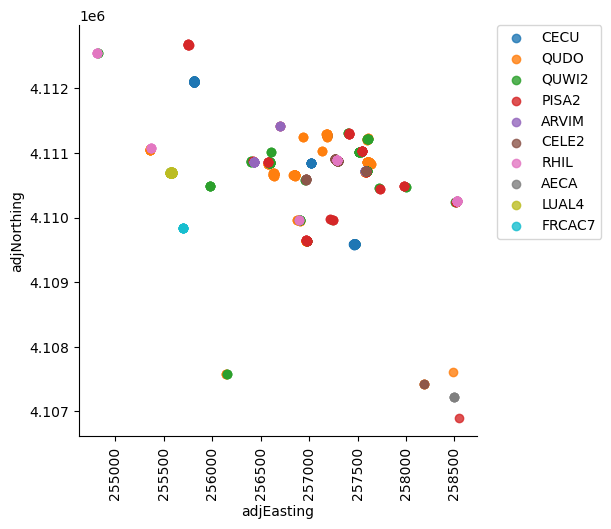

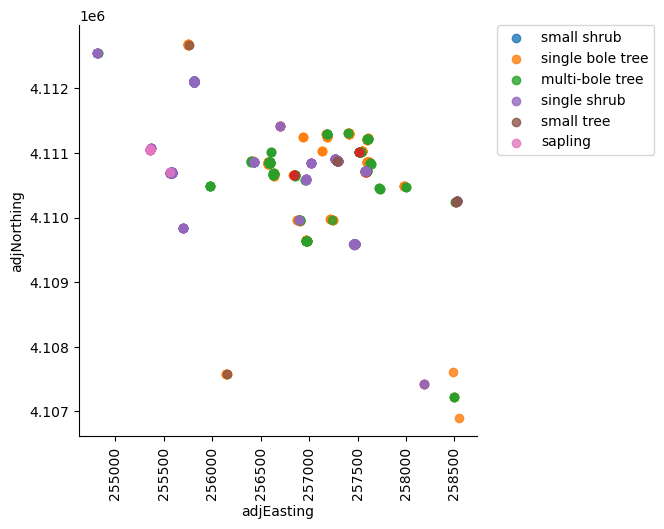

In [70]:
# Use the 'hue' argument to color by species
sns.lmplot(x="adjEasting", y="adjNorthing", data=veg, fit_reg=False, hue='taxonID', legend=False);
# anchor the legend to outside right of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.xticks(rotation=90);

# Use the 'hue' argument to color by species
sns.lmplot(x="adjEasting", y="adjNorthing", data=veg, fit_reg=False, hue='growthForm', legend=False);
# anchor the legend to outside right of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.xticks(rotation=90);

Below are links to each of the USDA plant profiles. 

USDA Plant Profiles:
- https://plants.usda.gov/core/profile?symbol=qudo - Quercus douglasii (blue oak)
- https://plants.usda.gov/core/profile?symbol=cecu - Ceanothus cuneatus (buckbrush)
- https://plants.usda.gov/core/profile?symbol=QUWI2 - Quercus wislizeni (interior live oak)
- https://plants.usda.gov/core/profile?symbol=PISA2 - Pinus sabiniana (california foothill pine)
- https://plants.usda.gov/core/profile?symbol=CELE2 - Ceanothus leucodermis (chaparral whitethorn) *shrub
- https://plants.usda.gov/core/profile?symbol=LUAL4 - Lupinus albifrons (silver lupine) *shrub
- https://plants.usda.gov/core/profile?symbol=ARVIM - Arctostaphylos viscida (Mariposa manzanita) *shrub tree
- https://plants.usda.gov/core/profile?symbol=RHIL - Rhamnus ilicifolia (hollyleaf redberry) *shrub tree

Plot only the single bole trees (`trees_sb_subset`):

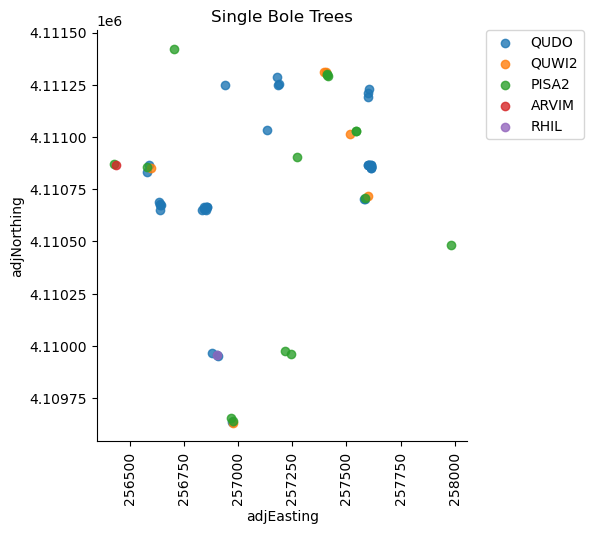

In [71]:
sns.lmplot(x="adjEasting", y="adjNorthing", data=trees_sb_subset, fit_reg=False, hue='taxonID', legend=False);
# anchor the legend to outside right of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.title('Single Bole Trees'); plt.xticks(rotation=90);

Most of the single-bole trees are Oaks (QUDO), (QUWI2). 

Next, extract the CHM values corresponding to each of the veg data points. You can do this in several different ways and with several different Python packages. We will show using `rasterio` (imported as `rio`) as well as `georasters`, which provides more advanced extraction options.

In [72]:
# read in with rasterio
chm_merged = rio.open("SJER_2024_CHM_merged.tif")

Extract the CHM value corresponding to each of the trees in the TOS single-bole tree dataset (trees_sb_subset):

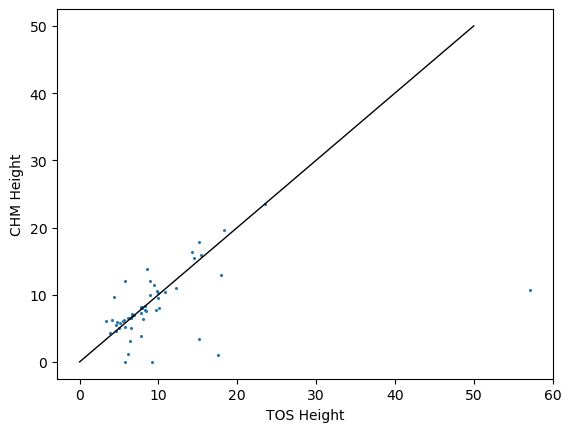

In [73]:
valCHM = list(rio.sample.sample_gen(chm_merged, 
                                tuple(zip(trees_sb_subset["adjEasting"], 
                                          trees_sb_subset["adjNorthing"])),
                                masked=True))

fig, ax = plt.subplots()

ax.plot((0,50), (0,50), linewidth=1, color="black")
ax.scatter(trees_sb_subset.height, valCHM, s=1.5)

ax.set_xlabel("TOS Height")
ax.set_ylabel("CHM Height")

plt.show()

There is fairly good alignment between the CHM heights and TOS heights, with the exception of a few outliers. Keep in mind that anything above the 1-1 line (CHM height > TOS height) might represent understory, as the CHM represents the canopy height. There may be other reasons for outliers - including geographic mismatch. Say the point locations between the TOS and Lidar-derived positions are off by a meter, the lidar could be detecting ground where the TOS data includes a tree. In the plot above we can see several examples where the CHM height is 0 and the TOS height is > 5 m. You may need to either adjust point locations, or filter out these outliers to exclude them from the model. 

You can also look at the stem diameter v. CHM height. There should be a positive correlation, but more scatter is expected.

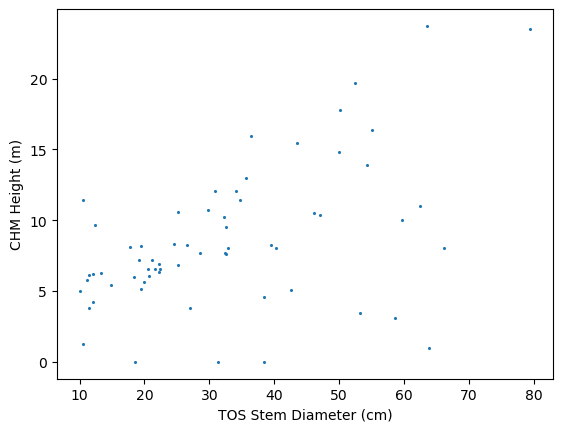

In [78]:
# make a plot of stemDiameter v. CHM height
fig, ax = plt.subplots()

ax.scatter(trees_sb_subset.stemDiameter, valCHM, s=1.5)

ax.set_xlabel("TOS Stem Diameter (cm)")
ax.set_ylabel("CHM Height (m)")

plt.show()

Depending on your approach, you may need to filter out outliers and/or remove the understory plants. Remember the CHM represents the canopy trees, so can mask the understory. See the Veg Structure and CHM lesson (https://www.neonscience.org/resources/learning-hub/tutorials/tree-heights-veg-structure-chm) for some ideas on further filtering.

We can also make a function for plotting the rasters, this is optional but another way to display the CHM data.

In [79]:
def plot_raster(band_array,image_extent,title,cmap_title,colormap,colormap_limits):
    plt.imshow(band_array,extent=image_extent)
    cbar = plt.colorbar(); plt.set_cmap(colormap); plt.clim(colormap_limits)
    cbar.set_label(cmap_title,rotation=270,labelpad=20)
    plt.title(title); ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90)

In [80]:
pip install georasters

6619.07s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 31.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 35.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 31.8 MB/s eta 0:00:00a 0:00:01
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=880a837fed98138adec18b85fad5619e6b47313f6b1d1ba6296a092a7dcd30ba
  Stored in directory: /home/skwirl/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
  Created wheel for spint: filename=spint-1.0.7-py3-none-any.whl size=31355 

In [82]:
import georasters as gr

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/climber/anaconda3/envs/jhub/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_121096/4019902281.py", line 1, in <module>
    import georasters as gr
  File "/home/climber/anaconda3/envs/jhub/lib/python3.11/site-packages/georasters/__init__.py", line 3, in <module>
    from .georasters import get_geo_info, map_pixel, map_pixel_inv, aggregate, create_geotiff, align_rasters, \
  File "/home/climber/anaconda3/envs/jhub/lib/python3.11/site-packages/georasters/georasters.py", line 38, in <module>
    from skimage.measure import block_reduce
  File "/home/climber/anaconda3/envs/jhub/lib/python3.11/site-packages/skimage/measure/__init__.py", line 5, in <module>
    from ._polygon import approximate_polygon, subdivide_polygon
  File "/home/climber/anaconda3/envs/jhub/lib/python3.11/site-packages/skimage/measure/_polygon.py", line 2, i

Use the Python `georasters` package (imported as `gr`) to read in the mosaicked raster. This gives us a little more flexibility for extraction (eg. we can select the max CHM value within a given radius).

In [81]:
sjer_chm = gr.from_file('SJER_2024_CHM_merged.tif')
sjer_chm_array=sjer_chm.raster.data
sjer_chm_extent=[sjer_chm.bounds[0],sjer_chm.bounds[2],sjer_chm.bounds[1],sjer_chm.bounds[3]]

NameError: name 'gr' is not defined

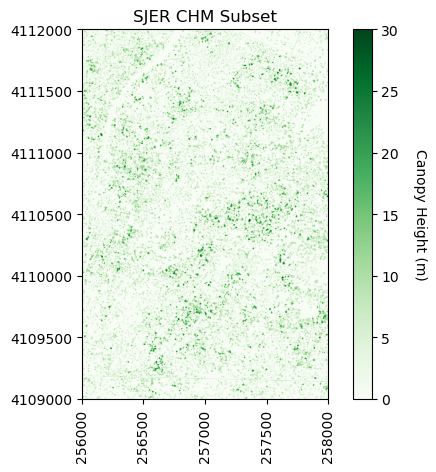

In [44]:
plot_raster(sjer_chm_array,sjer_chm_extent,'SJER CHM Subset','Canopy Height (m)','Greens',[0,30])

Let's select the CHM height, and the maximum CHM height within a 3 m radius. This may help with cases where there is geographic mismatch between the TOS and CHM data.

In [45]:
tree_training_df = trees_sb_subset[(np.isfinite(trees_sb_subset['adjEasting'])) & (np.isfinite(trees_sb_subset['adjNorthing']))].reset_index(drop=True)
for i,row in tree_training_df.iterrows():
    chm_height = sjer_chm.map_pixel(tree_training_df.loc[i,'adjEasting'],tree_training_df.loc[i,'adjNorthing'])  
    chm_height_max3 = sjer_chm.extract(tree_training_df.loc[i,'adjEasting'],tree_training_df.loc[i,'adjNorthing'],radius=3).max()
    tree_training_df.at[i,'chm_height'] = chm_height
    tree_training_df.at[i,'chm_height_max3'] = chm_height_max3
tree_training_df[['date_AI','individualID','scientificName','taxonID','family','growthForm','plantStatus','stemDiameter','height','chm_height','chm_height_max3']].head(5)

,date_AI,individualID,scientificName,taxonID,family,growthForm,plantStatus,stemDiameter,height,chm_height,chm_height_max3
0,2016-11-15 00:00:00,NEON.PLA.D17.SJER.00001,Quercus douglasii Hook. & Arn.,QUDO,Fagaceae,single bole tree,Live,28.5,8.3,8.75,8.75
1,2016-11-11 00:00:00,NEON.PLA.D17.SJER.00014,Quercus douglasii Hook. & Arn.,QUDO,Fagaceae,single bole tree,Live,32.3,9.9,9.78,10.30
2,2016-11-11 00:00:00,NEON.PLA.D17.SJER.00017,Quercus douglasii Hook. & Arn.,QUDO,Fagaceae,single bole tree,Live,42.6,6.5,4.02,6.18
3,2023-11-29 00:00:00,NEON.PLA.D17.SJER.00037,Quercus wislizeni A. DC.,QUWI2,Fagaceae,single bole tree,Standing dead,19.4,5.8,0.00,6.83
4,2016-11-09 00:00:00,NEON.PLA.D17.SJER.00040,Quercus douglasii Hook. & Arn.,QUDO,Fagaceae,single bole tree,Live,40.3,7.9,8.03,9.65


As you can see with the 3rd record (`NEON.PLA.D17.SJER.00037`), the `chm_height` is 0, but the `chm_height_max3` is 6.18, much closer to the TOS measured height of 6.5. This may be a better variable to use.

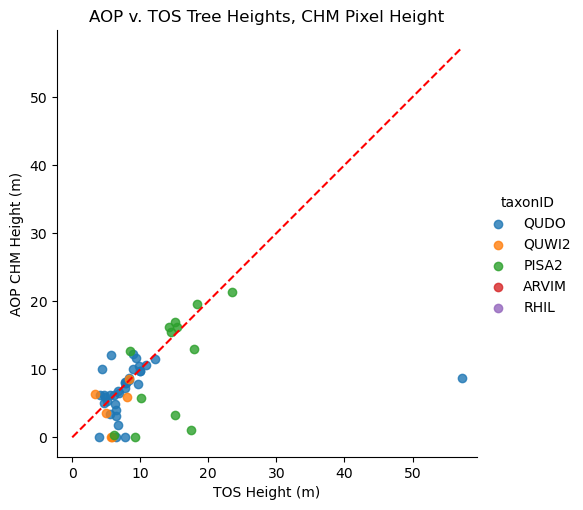

In [46]:
# Plot TOS v. CHM heights for comparison, colored by taxonID:
sns.lmplot(tree_training_df, x='height', y='chm_height', hue='taxonID', fit_reg=False); ax = plt.gca()
#plot 1-1 line for comparison
compare_line = np.arange(0,ceil(np.nanmax([tree_training_df['height'],tree_training_df['chm_height_max3']])))
ax.plot(compare_line,compare_line,'--',color='red')
ax.axis('equal')
ax.set_title('AOP v. TOS Tree Heights, CHM Pixel Height')
ax.set_xlabel('TOS Height (m)')
ax.set_ylabel('AOP CHM Height (m)');

There is one Oak with an anomalously tall height of 57 m. We can look at this more closely to see what's going on.

In [47]:
tree_training_df[tree_training_df['height']>50][['height','chm_height','chm_height_max3','stemDiameter','dataQF_AI']]

,height,chm_height,chm_height_max3,stemDiameter,dataQF_AI
34,57.2,8.77,11.86,29.8,legacyData


Legacy data was collected before data collection app (Fulcrum) was available, so are subject to more human/recorder error. This may have been off by a decimal place. While the stem diameter seems reasonable, you may choose to remove this record, as we do not expect any Oak trees this tall.

In [48]:
tree_training_df = tree_training_df[tree_training_df['height']<50]

The CHM heights tend to be lower than field-measured heights, which fits with this plot. We interpret values above the 1-1 line to be understory trees, which we can filter out according to some threshold. Let's try a ratio of 0.75 to start:

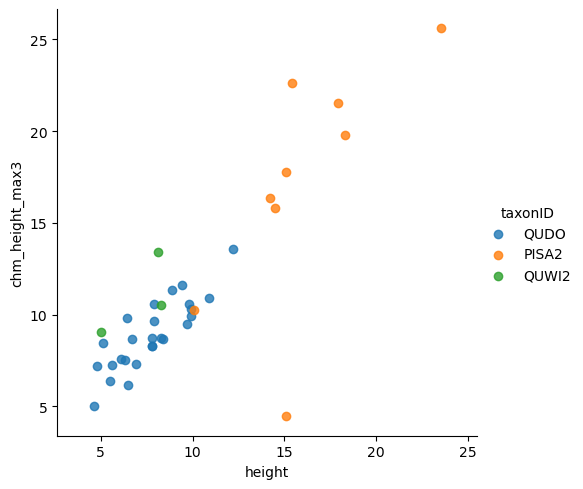

In [49]:
training_df_filtered = tree_training_df.loc[(tree_training_df['height'] > 0.75*tree_training_df['chm_height']) & (tree_training_df['chm_height']>2)]
sns.lmplot(training_df_filtered, x='height', y='chm_height_max3', hue='taxonID', fit_reg=False);
plt.axis('equal');

You may also wish to remove the PISA2 outlier, where the TOS height is ~ 15m but the chm_height_max3 < 5m. This may be due to geographic mismatch, or some other manual error.

In [51]:
training_df_filtered[(training_df_filtered['chm_height_max3']<5) & (training_df_filtered['taxonID'] == 'PISA2')][['individualID','taxonID','height','chm_height','chm_height_max3','stemDiameter']]

,individualID,taxonID,height,chm_height,chm_height_max3,stemDiameter
60,NEON.PLA.D17.SJER.04443,PISA2,15.1,3.23,4.46,53.3


This may be off due to a geographic mismatch, or some other error. Remove this record as well, to be safe.

In [52]:
training_df_filtered = training_df_filtered[training_df_filtered['individualID'] != 'NEON.PLA.D17.SJER.04443']

In [53]:
len(training_df_filtered)

37

### Biomass calculations - allometric equations

Now that we've identified and filtered out the outliers, let's calculate biomass for the filtered dataframe. For multi-bole trees, calculate biomass for each bole according to the standard formula, and then aggregate by `individualID`. 

**USDA Plant Profiles:**
- https://plants.usda.gov/core/profile?symbol=qudo - Quercus douglasii (blue oak)
- https://plants.usda.gov/core/profile?symbol=QUWI2 - Quercus wislizeni (interior live oak)
- https://plants.usda.gov/core/profile?symbol=PISA2 - Pinus sabiniana (california foothill pine)

**Biomass equation:**

$Biomass = exp(\beta_0 + \beta_1 ln(DBH))$

where
- Biomass = total aboveground biomass (kg) for trees 2.5cm dbh and larger
- DBH = diameter at breast height (cm)

Make a dataframe containing the allometry parameters. We suggest using the following references to obtain these values:

Updated generalized biomass equations for North American tree species.
David C. Chojnacky, Linda S. Heath, Jennifer C. Jenkins 2013
https://academic.oup.com/forestry/article-abstract/87/1/129/602137?redirectedFrom=fulltext

Comprehensive database of diameter-based biomass regressions for North American tree species. 
Jennifer C. Jenkins, David C. Chojnacky, Linda S. Heath, Richard A. Birdsey 2004
https://research.fs.usda.gov/treesearch/7058

In [54]:
allometry_params_df = pd.DataFrame(columns=['speciesGroup','taxonID','B0','B1'])
allometry_params_df.loc[len(allometry_params_df)] = ['Hard maple/oak/hickory/beech','QUDO',-2.0127,2.4342]
allometry_params_df.loc[len(allometry_params_df)] = ['Hard maple/oak/hickory/beech','QUWI2',-2.0127,2.4342]
allometry_params_df.loc[len(allometry_params_df)] = ['Pine','PISA2',-2.5356,2.4349]
allometry_params_df

,speciesGroup,taxonID,B0,B1
0,Hard maple/oak/hickory/beech,QUDO,-2.0127,2.4342
1,Hard maple/oak/hickory/beech,QUWI2,-2.0127,2.4342
2,Pine,PISA2,-2.5356,2.4349


Now that we've defined the allometry parameters, we can write a function to calculate biomass and apply this to the training dataframe:

In [55]:
def calc_biomass(B0,B1,DBH):
    biomass = np.exp(B0+B1*np.log(DBH))
    return biomass

for i,row in tree_training_df.iterrows():
    #find allometry params corresponding to taxonID
    allometry_params = allometry_params_df.loc[(allometry_params_df['taxonID'] == tree_training_df.loc[i,'taxonID'])]
    B0 = allometry_params['B0'].item(); #print(B0)
    B1 = allometry_params['B1'].item(); #print(B1)
    DBH = tree_training_df.loc[i,'stemDiameter']
    tree_training_df.at[i,'biomass'] = calc_biomass(B0,B1,DBH)

Finally, save the training dataframe to a csv. You can select fewer or more columns as desired. You can expand upon this by adding region properties from the CHM data. This will be expanded upon in a later iteration.

In [59]:
final_training_df = tree_training_df[['date_AI','individualID','adjEasting','adjNorthing','taxonID','growthForm','plantStatus','stemDiameter','height','chm_height_max3','chm_height','biomass']]
final_training_df.head()

,date_AI,individualID,adjEasting,adjNorthing,taxonID,growthForm,plantStatus,stemDiameter,height,chm_height_max3,chm_height,biomass
0,2016-11-15 00:00:00,NEON.PLA.D17.SJER.00001,257179.618541,4.111285e+06,QUDO,single bole tree,Live,28.5,8.3,8.75,8.75,464.813630
1,2016-11-11 00:00:00,NEON.PLA.D17.SJER.00014,257600.854612,4.111210e+06,QUDO,single bole tree,Live,32.3,9.9,10.30,9.78,630.371074
2,2016-11-11 00:00:00,NEON.PLA.D17.SJER.00017,257599.870838,4.111193e+06,QUDO,single bole tree,Live,42.6,6.5,6.18,4.02,1236.529103
3,2023-11-29 00:00:00,NEON.PLA.D17.SJER.00037,257517.019886,4.111014e+06,QUWI2,single bole tree,Standing dead,19.4,5.8,6.83,0.00,182.247873
4,2016-11-09 00:00:00,NEON.PLA.D17.SJER.00040,257599.099435,4.110864e+06,QUDO,single bole tree,Live,40.3,7.9,9.65,8.03,1080.261851


In [60]:
final_training_df.to_csv('tree_training_df.csv',index=False)

Now you can use this df as a trianing dataset. You may choose to further filter by only including Live trees, or 